# Sesión 11:  ALGORITMOS GENÉTICOS Y EVOLUCIÓN DE LA POBLACIÓN
Realizado por:

**- Ruelas Flores, César Diego**

### Variables Globales

In [1]:
# las variables globales se definirán en proceso de creacion del lab
URL = "https://raw.githubusercontent.com/AzShet/Data_Mining-LAB11/refs/heads/develop/Advertising-1.csv"
COLUMNAS = ["TV", "Radio", "Newspaper"]

In [5]:
import polars as pl
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from deap import base, creator, tools, algorithms
import random
import matplotlib.pyplot as plt

In [2]:
# !pip install polars numpy scikit-learn matplotlib (LIBRERIAS NECESARIAS)

## FUNCIONES DE UTILIDAD

In [14]:
%%writefile utils.py
"""
Funciones reutilizables para el proyecto de análisis de datos de publicidad con algoritmos genéticos.

Autor: César Diego Ruelas Flores
Fecha: 28-may-2025
"""
import polars as pl
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from deap import base, creator, tools, algorithms
import random
import matplotlib.pyplot as plt

def cargar_datos(url):
    """Carga los datos desde una URL y devuelve un DataFrame de Polars."""
    return pl.read_csv(url)

def tratar_outliers_iqr(df, columnas=None):
    """Elimina outliers utilizando el método del rango intercuartílico (IQR)."""
    if columnas is None:
        columnas = df.columns

    df_tratado = df.clone()
    for col in columnas:
        if df[col].dtype in [pl.Float64, pl.Float32, pl.Int64, pl.Int32]:
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            limite_inferior = Q1 - 1.5 * IQR
            limite_superior = Q3 + 1.5 * IQR
            mediana = df[col].median()

            df_tratado = df_tratado.with_columns(
                pl.when((pl.col(col) < limite_inferior) | (pl.col(col) > limite_superior))
                .then(mediana)
                .otherwise(pl.col(col))
                .alias(col)
            )
    return df_tratado

def escalar_datos(df, columnas=None, metodo='minmax'):
    """Escala los datos usando MinMaxScaler o StandardScaler."""
    if columnas is None:
        columnas = df.columns

    df_escalado = df.clone()

    if metodo == 'minmax':
        for col in columnas:
            if df[col].dtype in [pl.Float64, pl.Float32, pl.Int64, pl.Int32]:
                min_val = df[col].min()
                max_val = df[col].max()
                df_escalado = df_escalado.with_columns(
                    ((pl.col(col) - min_val) / (max_val - min_val)).alias(col)
                )

    return df_escalado

def separar_variables(df, variable_objetivo):
    """Separa las variables predictoras de la variable objetivo."""
    X = df.drop(variable_objetivo)
    y = df.select(variable_objetivo)
    return X, y

def convertir_a_numpy(df):
    """Convierte un DataFrame de Polars a array de numpy."""
    return df.to_numpy()

def crear_fitness_function(X, y):
    """Crea la función de fitness para el algoritmo genético."""
    def evaluar_individuo(individual):
        # Seleccionar características basadas en el individuo
        selected_features = [i for i, bit in enumerate(individual) if bit == 1]

        if len(selected_features) == 0:
            return (0.0,)  # Si no hay características seleccionadas, fitness = 0

        X_selected = X[:, selected_features]

        # Usar validación cruzada para evaluar el modelo
        modelo = LinearRegression()
        scores = cross_val_score(modelo, X_selected, y.ravel(), cv=5, scoring='r2')

        return (np.mean(scores),)

    return evaluar_individuo

def configurar_algoritmo_genetico(n_features):
    """Configura el algoritmo genético usando DEAP."""
    # Crear tipos de fitness y individuos
    if hasattr(creator, "FitnessMax"):
        del creator.FitnessMax
    if hasattr(creator, "Individual"):
        del creator.Individual

    creator.create("FitnessMax", base.Fitness, weights=(1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMax)

    toolbox = base.Toolbox()
    toolbox.register("attr_bool", random.randint, 0, 1)
    toolbox.register("individual", tools.initRepeat, creator.Individual, 
                     toolbox.attr_bool, n=n_features)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    return toolbox

def ejecutar_algoritmo_genetico(X, y, n_pop=50, cx_pb=0.7, mut_pb=0.2, n_gen=50):
    """Ejecuta el algoritmo genético para selección de características."""
    n_features = X.shape[1]

    # Configurar algoritmo genético
    toolbox = configurar_algoritmo_genetico(n_features)

    # Registrar operadores
    fitness_func = crear_fitness_function(X, y)
    toolbox.register("evaluate", fitness_func)
    toolbox.register("mate", tools.cxTwoPoint)
    toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
    toolbox.register("select", tools.selTournament, tournsize=3)

    # Crear población inicial
    pop = toolbox.population(n=n_pop)

    # Estadísticas
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("max", np.max)
    stats.register("min", np.min)

    # Ejecutar algoritmo genético
    pop, logbook = algorithms.eaSimple(pop, toolbox, cxpb=cx_pb, mutpb=mut_pb, 
                                       ngen=n_gen, stats=stats, verbose=True)

    return pop, logbook

def obtener_mejor_individuo(population):
    """Obtiene el mejor individuo de la población."""
    return tools.selBest(population, k=1)[0]

def entrenar_modelo_final(X, y, selected_features, test_size=0.2, random_state=42):
    """Entrena el modelo final con las características seleccionadas."""
    # Seleccionar características
    X_selected = X[:, selected_features]

    # Dividir datos
    X_train, X_test, y_train, y_test = train_test_split(
        X_selected, y.ravel(), test_size=test_size, random_state=random_state
    )

    # Entrenar modelo
    modelo = LinearRegression()
    modelo.fit(X_train, y_train)

    # Predicciones
    y_pred_train = modelo.predict(X_train)
    y_pred_test = modelo.predict(X_test)

    # Métricas
    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)

    return modelo, r2_train, r2_test

def graficar_evolucion(logbook):
    """Grafica la evolución del algoritmo genético."""
    gen = logbook.select("gen")
    avg_fitness = logbook.select("avg")
    max_fitness = logbook.select("max")

    plt.figure(figsize=(10, 6))
    plt.plot(gen, avg_fitness, label='Promedio', linewidth=2)
    plt.plot(gen, max_fitness, label='Máximo', linewidth=2)
    plt.xlabel('Generación')
    plt.ylabel('R² Score')
    plt.title('Evolución del Coeficiente de Determinación (R²)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

def mostrar_caracteristicas_seleccionadas(mejor_individuo, nombres_columnas):
    """Muestra las características seleccionadas por el algoritmo genético."""
    selected_features = [i for i, bit in enumerate(mejor_individuo) if bit == 1]
    selected_names = [nombres_columnas[i] for i in selected_features]

    print("Características seleccionadas:")
    for i, name in enumerate(selected_names):
        print(f"  {i+1}. {name}")

    return selected_features, selected_names

def analizar_outliers_multivariado(df, umbral=3):
    """Detecta outliers multivariados usando la distancia de Mahalanobis."""
    # Convertir a numpy para cálculos
    data = df.to_numpy()

    # Calcular media y matriz de covarianza
    mean = np.mean(data, axis=0)
    cov = np.cov(data.T)

    # Calcular distancia de Mahalanobis
    try:
        inv_cov = np.linalg.inv(cov)
        mahal_dist = []

        for row in data:
            diff = row - mean
            mahal_dist.append(np.sqrt(diff.T @ inv_cov @ diff))

        # Identificar outliers
        mahal_dist = np.array(mahal_dist)
        outliers = mahal_dist > umbral

        return outliers, mahal_dist
    except np.linalg.LinAlgError:
        print("Error: Matriz de covarianza singular. No se pueden detectar outliers multivariados.")
        return np.zeros(len(data), dtype=bool), np.zeros(len(data))

def probar_multiples_configuraciones(X, y, configuraciones):
    """Prueba múltiples configuraciones del algoritmo genético."""
    resultados = []

    for i, config in enumerate(configuraciones):
        print(f"\nProbando configuración {i+1}/{len(configuraciones)}")
        print(f"N_POP: {config['n_pop']}, CX_PB: {config['cx_pb']}, MUT_PB: {config['mut_pb']}, N_GEN: {config['n_gen']}")

        pop, logbook = ejecutar_algoritmo_genetico(
            X, y, 
            n_pop=config['n_pop'],
            cx_pb=config['cx_pb'],
            mut_pb=config['mut_pb'],
            n_gen=config['n_gen']
        )

        mejor_individuo = obtener_mejor_individuo(pop)
        mejor_fitness = mejor_individuo.fitness.values[0]

        resultados.append({
            'configuracion': config,
            'mejor_fitness': mejor_fitness,
            'mejor_individuo': mejor_individuo,
            'logbook': logbook
        })

    return resultados

Overwriting utils.py


In [15]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
from utils import *

## Parte A: Preprocesamiento de la Información

**Carga de Datos**

In [16]:
url = "https://raw.githubusercontent.com/AzShet/Data_Mining-LAB11/refs/heads/develop/Advertising-1.csv"
df = cargar_datos(url)

print("1. Información básica del dataset:")
print(f"   - Forma del dataset: {df.shape}")
print(f"   - Columnas: {df.columns}")
print(f"   - Primeras 5 filas:")
print(df.head())

1. Información básica del dataset:
   - Forma del dataset: (200, 4)
   - Columnas: ['TV', 'Radio', 'Newspaper', 'Sales']
   - Primeras 5 filas:
shape: (5, 4)
┌───────┬───────┬───────────┬───────┐
│ TV    ┆ Radio ┆ Newspaper ┆ Sales │
│ ---   ┆ ---   ┆ ---       ┆ ---   │
│ f64   ┆ f64   ┆ f64       ┆ f64   │
╞═══════╪═══════╪═══════════╪═══════╡
│ 230.1 ┆ 37.8  ┆ 69.2      ┆ 22.1  │
│ 44.5  ┆ 39.3  ┆ 45.1      ┆ 10.4  │
│ 17.2  ┆ 45.9  ┆ 69.3      ┆ 9.3   │
│ 151.5 ┆ 41.3  ┆ 58.5      ┆ 18.5  │
│ 180.8 ┆ 10.8  ┆ 58.4      ┆ 12.9  │
└───────┴───────┴───────────┴───────┘


In [17]:
# 2. Análisis de datos faltantes
print("\n2. Análisis de datos faltantes:")
datos_faltantes = df.null_count()
print(datos_faltantes)


2. Análisis de datos faltantes:
shape: (1, 4)
┌─────┬───────┬───────────┬───────┐
│ TV  ┆ Radio ┆ Newspaper ┆ Sales │
│ --- ┆ ---   ┆ ---       ┆ ---   │
│ u32 ┆ u32   ┆ u32       ┆ u32   │
╞═════╪═══════╪═══════════╪═══════╡
│ 0   ┆ 0     ┆ 0         ┆ 0     │
└─────┴───────┴───────────┴───────┘


In [ ]:
# 3. Eliminar filas con datos faltantes (aunque no hay)
df_limpio = df
print(f"\n3. Dataset después de eliminar NaN: {df_limpio.shape}")


3. Dataset después de eliminar NaN: (200, 4)


In [19]:
# 4. Análisis descriptivo
print("\n4. Estadísticas descriptivas:")
print(df_limpio.describe())

# 5. Detección de outliers univariados
print("\n5. Análisis de outliers univariados:")
for col in df_limpio.columns:
    Q1 = df_limpio[col].quantile(0.25)
    Q3 = df_limpio[col].quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR
    
    outliers = df_limpio.filter(
        (pl.col(col) < limite_inferior) | (pl.col(col) > limite_superior)
    ).shape[0]
    
    print(f"   - {col}: {outliers} outliers detectados")

# 6. Tratamiento de outliers univariados
df_sin_outliers = tratar_outliers_iqr(df_limpio)
print(f"\n6. Dataset después del tratamiento de outliers: {df_sin_outliers.shape}")

# 7. Análisis de outliers multivariados
print("\n7. Análisis de outliers multivariados:")
outliers_multi, distancias = analizar_outliers_multivariado(df_sin_outliers)
print(f"   - Outliers multivariados detectados: {np.sum(outliers_multi)}")

# 8. Escalamiento de datos
print("\n8. Escalamiento de datos:")
df_escalado = escalar_datos(df_sin_outliers)
print("   - Datos escalados usando MinMaxScaler")
print("   - Estadísticas después del escalamiento:")
print(df_escalado.describe())



4. Estadísticas descriptivas:
shape: (9, 5)
┌────────────┬───────────┬───────────┬───────────┬──────────┐
│ statistic  ┆ TV        ┆ Radio     ┆ Newspaper ┆ Sales    │
│ ---        ┆ ---       ┆ ---       ┆ ---       ┆ ---      │
│ str        ┆ f64       ┆ f64       ┆ f64       ┆ f64      │
╞════════════╪═══════════╪═══════════╪═══════════╪══════════╡
│ count      ┆ 200.0     ┆ 200.0     ┆ 200.0     ┆ 200.0    │
│ null_count ┆ 0.0       ┆ 0.0       ┆ 0.0       ┆ 0.0      │
│ mean       ┆ 147.0425  ┆ 23.264    ┆ 30.554    ┆ 14.0225  │
│ std        ┆ 85.854236 ┆ 14.846809 ┆ 21.778621 ┆ 5.217457 │
│ min        ┆ 0.7       ┆ 0.0       ┆ 0.3       ┆ 1.6      │
│ 25%        ┆ 74.7      ┆ 10.0      ┆ 12.8      ┆ 10.4     │
│ 50%        ┆ 149.8     ┆ 23.3      ┆ 25.9      ┆ 12.9     │
│ 75%        ┆ 218.5     ┆ 36.5      ┆ 45.1      ┆ 17.4     │
│ max        ┆ 296.4     ┆ 49.6      ┆ 114.0     ┆ 27.0     │
└────────────┴───────────┴───────────┴───────────┴──────────┘

5. Análisis de outliers 

## Parte B: Algoritmo Genético

In [20]:

# ========================= PARTE B: ALGORITMO GENÉTICO =========================
print("\n" + "=" * 60)
print("PARTE B: ALGORITMO GENÉTICO PARA SELECCIÓN DE CARACTERÍSTICAS")
print("=" * 60)

# 9. Separar variables predictoras y objetivo
X_df, y_df = separar_variables(df_escalado, 'Sales')
print(f"\n9. Variables separadas:")
print(f"   - Características (X): {X_df.shape}")
print(f"   - Variable objetivo (y): {y_df.shape}")

# 10. Convertir a numpy arrays
X = convertir_a_numpy(X_df)
y = convertir_a_numpy(y_df)
nombres_caracteristicas = X_df.columns

print(f"\n10. Conversión a numpy arrays completada")
print(f"    - X shape: {X.shape}")
print(f"    - y shape: {y.shape}")

# 11. Configuraciones del algoritmo genético a probar
configuraciones = [
    {'n_pop': 30, 'cx_pb': 0.6, 'mut_pb': 0.1, 'n_gen': 30},
    {'n_pop': 50, 'cx_pb': 0.7, 'mut_pb': 0.2, 'n_gen': 40},
    {'n_pop': 70, 'cx_pb': 0.8, 'mut_pb': 0.3, 'n_gen': 50},
    {'n_pop': 100, 'cx_pb': 0.9, 'mut_pb': 0.1, 'n_gen': 60}
]

print(f"\n11. Probando {len(configuraciones)} configuraciones diferentes:")

# 12. Ejecutar múltiples configuraciones
resultados = probar_multiples_configuraciones(X, y, configuraciones)

# 13. Encontrar la mejor configuración
mejor_config_idx = np.argmax([r['mejor_fitness'] for r in resultados])
mejor_resultado = resultados[mejor_config_idx]

print(f"\n12. Mejor configuración encontrada:")
print(f"    - Índice: {mejor_config_idx + 1}")
print(f"    - Configuración: {mejor_resultado['configuracion']}")
print(f"    - Mejor fitness (R²): {mejor_resultado['mejor_fitness']:.4f}")


PARTE B: ALGORITMO GENÉTICO PARA SELECCIÓN DE CARACTERÍSTICAS

9. Variables separadas:
   - Características (X): (200, 3)
   - Variable objetivo (y): (200, 1)

10. Conversión a numpy arrays completada
    - X shape: (200, 3)
    - y shape: (200, 1)

11. Probando 4 configuraciones diferentes:

Probando configuración 1/4
N_POP: 30, CX_PB: 0.6, MUT_PB: 0.1, N_GEN: 30
gen	nevals	avg     	max     	min
0  	30    	0.489144	0.889283	0  
1  	25    	0.724832	0.889283	0.289392
2  	18    	0.888427	0.889283	0.887142
3  	16    	0.88914 	0.889283	0.887142
4  	20    	0.889283	0.889283	0.889283
5  	22    	0.879322	0.889283	0.5926  
6  	18    	0.889212	0.889283	0.887142
7  	19    	0.889283	0.889283	0.889283
8  	12    	0.889283	0.889283	0.889283
9  	20    	0.889283	0.889283	0.889283
10 	20    	0.889283	0.889283	0.889283
11 	19    	0.889283	0.889283	0.889283
12 	22    	0.889283	0.889283	0.889283
13 	14    	0.889283	0.889283	0.889283
14 	21    	0.889283	0.889283	0.889283
15 	19    	0.889283	0.889283	0.889

## Parte C: Modelo de regresión lineal

'Sales' será la variable objetivo


PARTE C: MODELO FINAL Y EVALUACIÓN
Características seleccionadas:
  1. TV
  2. Radio

14. Características seleccionadas: 2 de 3

15. Graficando evolución del algoritmo genético:


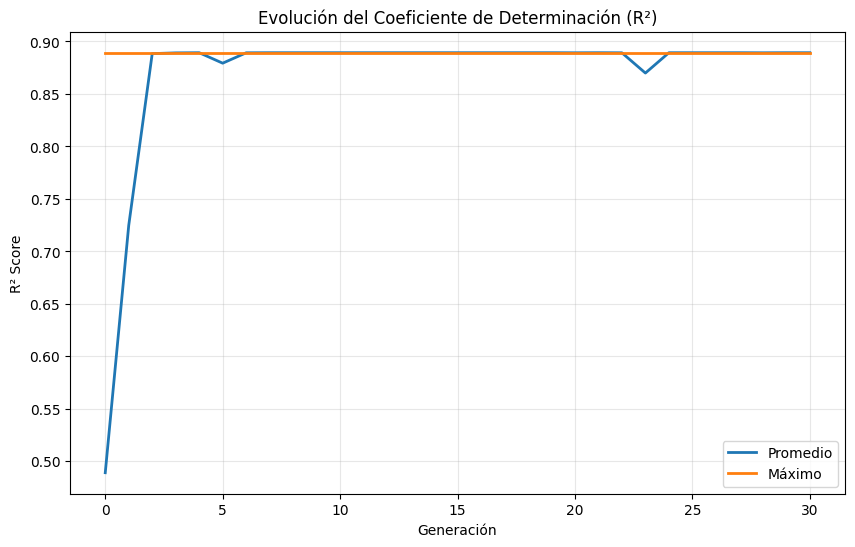


16. Entrenando modelo final con las características seleccionadas:
    - R² en entrenamiento (80%): 0.8956
    - R² en prueba (20%): 0.9006

17. Comparación con modelo usando todas las características:
    - R² en entrenamiento (todas las características): 0.8957
    - R² en prueba (todas las características): 0.8999

RESUMEN DE RESULTADOS
Dataset original: 200 filas, 4 columnas
Características originales: 3
Características seleccionadas: 2
Porcentaje de reducción: 33.3%

Mejor configuración del algoritmo genético:
  - N_POP: 30
  - CX_PB: 0.6
  - MUT_PB: 0.1
  - N_GEN: 30

Rendimiento del modelo:
  - Con características seleccionadas: R² = 0.9006
  - Con todas las características: R² = 0.8999
  - Mejora: +0.0006

Características seleccionadas:
  1. TV
  2. Radio

19. Graficando comparación de configuraciones:


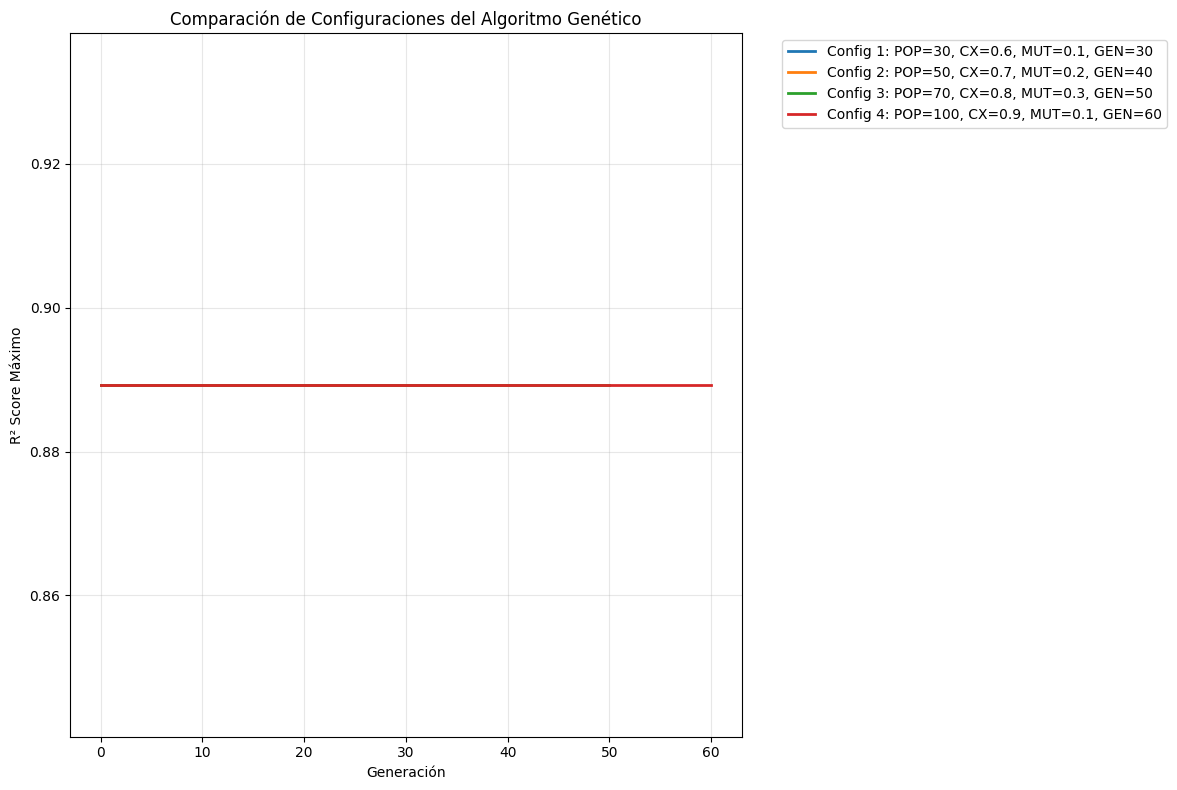


¡Análisis completado exitosamente!


In [21]:
# ========================= PARTE C: MODELO FINAL Y EVALUACIÓN =========================
print("\n" + "=" * 60)
print("PARTE C: MODELO FINAL Y EVALUACIÓN")
print("=" * 60)

# 14. Obtener las características seleccionadas
mejor_individuo = mejor_resultado['mejor_individuo']
caracteristicas_seleccionadas, nombres_seleccionados = mostrar_caracteristicas_seleccionadas(
    mejor_individuo, nombres_caracteristicas
)

print(f"\n14. Características seleccionadas: {len(caracteristicas_seleccionadas)} de {len(nombres_caracteristicas)}")

# 15. Graficar evolución del mejor resultado
print("\n15. Graficando evolución del algoritmo genético:")
graficar_evolucion(mejor_resultado['logbook'])

# 16. Entrenar modelo final
print("\n16. Entrenando modelo final con las características seleccionadas:")
modelo_final, r2_train, r2_test = entrenar_modelo_final(
    X, y, caracteristicas_seleccionadas, test_size=0.2, random_state=42
)

print(f"    - R² en entrenamiento (80%): {r2_train:.4f}")
print(f"    - R² en prueba (20%): {r2_test:.4f}")

# 17. Comparación con modelo usando todas las características
print("\n17. Comparación con modelo usando todas las características:")
modelo_completo, r2_train_completo, r2_test_completo = entrenar_modelo_final(
    X, y, list(range(X.shape[1])), test_size=0.2, random_state=42
)

print(f"    - R² en entrenamiento (todas las características): {r2_train_completo:.4f}")
print(f"    - R² en prueba (todas las características): {r2_test_completo:.4f}")

# 18. Resumen de resultados
print("\n" + "=" * 60)
print("RESUMEN DE RESULTADOS")
print("=" * 60)

print(f"Dataset original: {df.shape[0]} filas, {df.shape[1]} columnas")
print(f"Características originales: {len(nombres_caracteristicas)}")
print(f"Características seleccionadas: {len(caracteristicas_seleccionadas)}")
print(f"Porcentaje de reducción: {(1 - len(caracteristicas_seleccionadas)/len(nombres_caracteristicas))*100:.1f}%")

print(f"\nMejor configuración del algoritmo genético:")
for key, value in mejor_resultado['configuracion'].items():
    print(f"  - {key.upper()}: {value}")

print(f"\nRendimiento del modelo:")
print(f"  - Con características seleccionadas: R² = {r2_test:.4f}")
print(f"  - Con todas las características: R² = {r2_test_completo:.4f}")
diferencia = r2_test - r2_test_completo
if diferencia > 0:
    print(f"  - Mejora: +{diferencia:.4f}")
else:
    print(f"  - Pérdida: {diferencia:.4f}")

print(f"\nCaracterísticas seleccionadas:")
for i, nombre in enumerate(nombres_seleccionados):
    print(f"  {i+1}. {nombre}")

# 19. Gráfico adicional: Comparación de todas las configuraciones
print("\n19. Graficando comparación de configuraciones:")
plt.figure(figsize=(12, 8))

for i, resultado in enumerate(resultados):
    logbook = resultado['logbook']
    gen = logbook.select("gen")
    max_fitness = logbook.select("max")
    config = resultado['configuracion']
    
    plt.plot(gen, max_fitness, 
             label=f"Config {i+1}: POP={config['n_pop']}, CX={config['cx_pb']}, MUT={config['mut_pb']}, GEN={config['n_gen']}", 
             linewidth=2)

plt.xlabel('Generación')
plt.ylabel('R² Score Máximo')
plt.title('Comparación de Configuraciones del Algoritmo Genético')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n¡Análisis completado exitosamente!")
print("="*60)

## PyTest